# Multiple-criteria decision analysis (MCDA) with Evolutionary Methods
By Sina Azartash<br>
Johns Hopkins University: Whiting School of Eningeering <br>
sazarta1@jh.edu


##PyMCDM
####Python 3 library for solving multi-criteria decision-making (MCDM) problems.
#### By Sina Azartash Nov 2021
##### Library by Andrii Shekhovtsov, Last Updated Oct 2021

# Loading and Install

In [2]:
!pip install pymcdm

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import networkx as nx # Used only for PROMTEHEE I visualisation (could be omitted if unnecessary)

# Print nice-looking tables
from tabulate import tabulate

from pymcdm import methods as mcdm_methods
from pymcdm import weights as mcdm_weights
from pymcdm import normalizations as norm
from pymcdm import correlations as corr
from pymcdm.helpers import rankdata, rrankdata

 # For pretty printing
np.set_printoptions(suppress=True, precision=4)

# Obtain Data

## Load Data

**Car Evaluation Database** <br>
CAR          -      car acceptability <br>
PRICE        -      overall price <br>
buying        -     buying price <br>
maint         -     price of the maintenance <br>
TECH          -     technical characteristics <br>
COMFORT       -     comfort <br>
doors        -      number of doors <br>
persons     -       capacity in terms of persons to carry <br>
lug_boot     -      the size of luggage boot <br>
safety       -      estimated safety of the car <br>

**Auto-Mpg Data**<br>
mpg:           continuous <br>
cylinders:     multi-valued discrete <br>
displacement:  continuous  <br>
horsepower:    continuous <br>
weight:        continuous <br>
acceleration:  continuous <br>
model year:    multi-valued discrete <br>
origin:        multi-valued discrete <br>
car name:      string (unique for each instance) <br>

In [4]:

header1 = [
   'buying',
   'maint',
   'doors',  
   'persons',   
   'luggage',      
   'safety',
   'evaluation'
]
header2 = ['mpg',
    'cyln',
    'displ',
    'h_power',
    'weight',
    'accel',
    'm_year',
    'origin',
    'c_name'
]

url1 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
url2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
car = pd.read_csv(url1, names = header1, dtype = str)
auto = pd.read_csv(url2, sep = '\s+',names = header2)

In [5]:
car.head()

,buying,maint,doors,persons,luggage,safety,evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [6]:
auto.head()

,mpg,cyln,displ,h_power,weight,accel,m_year,origin,c_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Remove Uncessary Column
**Car.Data** <br>
the number of doors and persons is a personal choice, not necessarily quality <br>
**Auto.Data** <br> 
origin and car name are irrelevant 


In [7]:
car = car.drop(labels = ['doors','persons','evaluation'], axis = 1)
car.head()

,buying,maint,luggage,safety
0,vhigh,vhigh,small,low
1,vhigh,vhigh,small,med
2,vhigh,vhigh,small,high
3,vhigh,vhigh,med,low
4,vhigh,vhigh,med,med


In [8]:
auto = auto.drop(labels = ['origin','c_name','displ'], axis = 1)
auto.head()

,mpg,cyln,h_power,weight,accel,m_year
0,18.0,8,130.0,3504.0,12.0,70
1,15.0,8,165.0,3693.0,11.5,70
2,18.0,8,150.0,3436.0,11.0,70
3,16.0,8,150.0,3433.0,12.0,70
4,17.0,8,140.0,3449.0,10.5,70


# Data Processing


## Car.Data

In [9]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   buying   1728 non-null   object
 1   maint    1728 non-null   object
 2   luggage  1728 non-null   object
 3   safety   1728 non-null   object
dtypes: object(4)
memory usage: 54.1+ KB


In [10]:
car.describe()

,buying,maint,luggage,safety
count,1728,1728,1728,1728
unique,4,4,3,3
top,low,low,big,low
freq,432,432,576,576


In [11]:
car.head()

,buying,maint,luggage,safety
0,vhigh,vhigh,small,low
1,vhigh,vhigh,small,med
2,vhigh,vhigh,small,high
3,vhigh,vhigh,med,low
4,vhigh,vhigh,med,med


### Check For Null *Values*

In [12]:
car.isnull().any()

buying     False
maint      False
luggage    False
safety     False
dtype: bool

In [13]:
car.applymap(np.isreal).any()

buying     False
maint      False
luggage    False
safety     False
dtype: bool

No missing values or null values for Car.Data detected 

### Convert To Float
We convert ordinal categorical into numbers <br>
We check for null values before and after the conversions 

In [14]:
def whitespace_remover(dataframe):
    """
    A method to remove whitespaces
    """
    # iterating over the columns
    for i in dataframe.columns:
         
        # checking datatype of each columns
        if dataframe[i].dtype == 'object':
             
            # applying strip function on column
            dataframe[i] = dataframe[i].map(str.strip)
        else:
             
            # if condn. is False then it will do nothing.
            pass


In [15]:
car = car.astype('string')
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   buying   1728 non-null   string
 1   maint    1728 non-null   string
 2   luggage  1728 non-null   string
 3   safety   1728 non-null   string
dtypes: string(4)
memory usage: 54.1 KB


The code above is the alternative to car.astype('str'). The 'str" method keeps the dType as objects and following methods will consequently fail

In [16]:
whitespace_remover(car)

In [17]:
car.head()

,buying,maint,luggage,safety
0,vhigh,vhigh,small,low
1,vhigh,vhigh,small,med
2,vhigh,vhigh,small,high
3,vhigh,vhigh,med,low
4,vhigh,vhigh,med,med


In [18]:
#car.evaluation.replace(('unacc', 'acc', 'good', 'vgood'), (1, 2, 3, 4), inplace = True)
car.buying.replace(('vhigh', 'high', 'med', 'low'), (4, 3, 2, 1), inplace = True)
car.maint.replace(('vhigh', 'high', 'med', 'low'), (4, 3, 2, 1), inplace = True)
car.luggage.replace(('small','med','big'),(1,2,3),inplace=True)
car.safety.replace(('low','med','high'),(1,2,3),inplace=True)

Converting string to integers was very problematic. For some reason, car.evaluation.replace(dictionary, inplace=True) was not working. The error reporting was unable to compare string with in64. The dictionary map is the reccomend way on to tutorials, but it did not work. The code above is the working solution

In [19]:
car = car.astype('float')


In [20]:
car.head()

,buying,maint,luggage,safety
0,4.0,4.0,1.0,1.0
1,4.0,4.0,1.0,2.0
2,4.0,4.0,1.0,3.0
3,4.0,4.0,2.0,1.0
4,4.0,4.0,2.0,2.0


We need the value to be floats rather than integers

### Check For Null *Values*

In [21]:
car.isnull().any()

buying     False
maint      False
luggage    False
safety     False
dtype: bool

In [22]:
car.applymap(np.isreal).any()

buying     True
maint      True
luggage    True
safety     True
dtype: bool

**We have succesfull converted all values into floats**

### Delete Duplicates
We will consider rows that have the same specs as the same type of car and thus duplicates

In [23]:
car = car.drop_duplicates()
car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 1628
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buying   144 non-null    float64
 1   maint    144 non-null    float64
 2   luggage  144 non-null    float64
 3   safety   144 non-null    float64
dtypes: float64(4)
memory usage: 5.6 KB


### Normalize Data


In [24]:
car_np = np.array(car)
types = np.ones(4)
car_np[0:10]

array([[4., 4., 1., 1.],
       [4., 4., 1., 2.],
       [4., 4., 1., 3.],
       [4., 4., 2., 1.],
       [4., 4., 2., 2.],
       [4., 4., 2., 3.],
       [4., 4., 3., 1.],
       [4., 4., 3., 2.],
       [4., 4., 3., 3.],
       [4., 3., 1., 1.]])

In [25]:
max_matrix = norm.normalize_matrix(car_np, norm.max_normalization, types)
minmax_matrix = norm.normalize_matrix(car_np, norm.minmax_normalization, types)
#log_matrix = norm.normalize_matrix(car_np, norm.logaritmic_normalization, types) caused an overflow
linear_matrix = norm.normalize_matrix(car_np, norm.linear_normalization, types)

In [26]:
max_matrix[0:10]

array([[1.    , 1.    , 0.3333, 0.3333],
       [1.    , 1.    , 0.3333, 0.6667],
       [1.    , 1.    , 0.3333, 1.    ],
       [1.    , 1.    , 0.6667, 0.3333],
       [1.    , 1.    , 0.6667, 0.6667],
       [1.    , 1.    , 0.6667, 1.    ],
       [1.    , 1.    , 1.    , 0.3333],
       [1.    , 1.    , 1.    , 0.6667],
       [1.    , 1.    , 1.    , 1.    ],
       [1.    , 0.75  , 0.3333, 0.3333]])

In [27]:
minmax_matrix[0:10]

array([[1.    , 1.    , 0.    , 0.    ],
       [1.    , 1.    , 0.    , 0.5   ],
       [1.    , 1.    , 0.    , 1.    ],
       [1.    , 1.    , 0.5   , 0.    ],
       [1.    , 1.    , 0.5   , 0.5   ],
       [1.    , 1.    , 0.5   , 1.    ],
       [1.    , 1.    , 1.    , 0.    ],
       [1.    , 1.    , 1.    , 0.5   ],
       [1.    , 1.    , 1.    , 1.    ],
       [1.    , 0.6667, 0.    , 0.    ]])

In [28]:
linear_matrix[0:10]

array([[1.    , 1.    , 0.3333, 0.3333],
       [1.    , 1.    , 0.3333, 0.6667],
       [1.    , 1.    , 0.3333, 1.    ],
       [1.    , 1.    , 0.6667, 0.3333],
       [1.    , 1.    , 0.6667, 0.6667],
       [1.    , 1.    , 0.6667, 1.    ],
       [1.    , 1.    , 1.    , 0.3333],
       [1.    , 1.    , 1.    , 0.6667],
       [1.    , 1.    , 1.    , 1.    ],
       [1.    , 0.75  , 0.3333, 0.3333]])

It seems that linear_normalization produces that same matrix as max_matrix in this case.

In [29]:
linear_matrix == max_matrix

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
 

We decided to go with max_matrix because linear_matrix is shown above to be the same thing. Lograthmic_normalization caused an overflow and min_max matrix resulted in loss of information.

In [30]:
car_max_matrix = max_matrix

## Auto-mpg.data

In [31]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mpg      398 non-null    float64
 1   cyln     398 non-null    int64  
 2   h_power  398 non-null    object 
 3   weight   398 non-null    float64
 4   accel    398 non-null    float64
 5   m_year   398 non-null    int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 18.8+ KB


In [32]:
auto.describe()

,mpg,cyln,weight,accel,m_year
count,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,2970.424623,15.568090,76.010050
std,7.815984,1.701004,846.841774,2.757689,3.697627
min,9.000000,3.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,5140.000000,24.800000,82.000000


### Check For Null Values

In [33]:
auto.isnull().any()

mpg        False
cyln       False
h_power    False
weight     False
accel      False
m_year     False
dtype: bool

We are convinced that there are no null values, but what about non numeric values?

In [34]:
auto.applymap(np.isreal).any()

mpg         True
cyln        True
h_power    False
weight      True
accel       True
m_year      True
dtype: bool

We see that horsepower "h_power" has non numberic values. That should not be happening. We begin the imputation process by converting to float

In [35]:
h = pd.to_numeric(auto.h_power, errors = 'coerce')
idx = h.isna()
auto[idx]

,mpg,cyln,h_power,weight,accel,m_year
32,25.0,4,?,2046.0,19.0,71
126,21.0,6,?,2875.0,17.0,74
330,40.9,4,?,1835.0,17.3,80
336,23.6,4,?,2905.0,14.3,80
354,34.5,4,?,2320.0,15.8,81
374,23.0,4,?,3035.0,20.5,82


We find that horespower does have some non numeric values. They are all question marks. Fortunately, that is easy to replace. Below, we replace our question marks into null by forcing the to_numeric function

In [36]:
auto.h_power = pd.to_numeric(auto.h_power, errors = 'coerce')

In [37]:
auto.isna().sum()

mpg        0
cyln       0
h_power    6
weight     0
accel      0
m_year     0
dtype: int64

### Data Imputation
Instead of replacing with average value, I take the recommender approach using the KNN algorithm.

I print the number of nulls above and below to verify the algorithm is working correctly. For the KNNIMPUTER object, the default neighbors is 5. 

In [38]:
from sklearn.impute import KNNImputer
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(auto)
# transform the dataset
auto2 = imputer.transform(auto)
np.isnan(auto2).sum()

0

The numer of missing values is reported to be 0 indicating success. Below, I convert the Xtrans into a new dataframe and paste the omited column back on.

In [39]:
auto2 = pd.DataFrame(auto2, columns = ['mpg','cyln','h_power','weight','accel','m_year'])
auto2[idx]

,mpg,cyln,h_power,weight,accel,m_year
32,25.0,4.0,62.0,2046.0,19.0,71.0
126,21.0,6.0,93.0,2875.0,17.0,74.0
330,40.9,4.0,64.6,1835.0,17.3,80.0
336,23.6,4.0,108.6,2905.0,14.3,80.0
354,34.5,4.0,84.6,2320.0,15.8,81.0
374,23.0,4.0,90.4,3035.0,20.5,82.0


Below, I check to see if the missing value subframe with missing values matches the new transformed subframe with filled values

In [40]:
auto2.applymap(np.isreal).any()

mpg        True
cyln       True
h_power    True
weight     True
accel      True
m_year     True
dtype: bool

We sucessfully imputed the missing values in auto.data based on the KNN

In [41]:
auto = auto2

### Delete Duplicates

In [42]:
auto = auto.drop_duplicates()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mpg      398 non-null    float64
 1   cyln     398 non-null    float64
 2   h_power  398 non-null    float64
 3   weight   398 non-null    float64
 4   accel    398 non-null    float64
 5   m_year   398 non-null    float64
dtypes: float64(6)
memory usage: 21.8 KB


### Convert To Float

In [43]:
auto.isnull().any()

mpg        False
cyln       False
h_power    False
weight     False
accel      False
m_year     False
dtype: bool

We are convinced that there are no null values, but what about non numeric values?

In [44]:
auto.applymap(np.isreal).any()

mpg        True
cyln       True
h_power    True
weight     True
accel      True
m_year     True
dtype: bool

We have sucessfully confirmed that there are no more null values. We are done with data cleaning.

### Apply Normalization

In [45]:
auto_np = np.array(auto)
types = np.ones(4)
auto_np[0:10]

array([[  18. ,    8. ,  130. , 3504. ,   12. ,   70. ],
       [  15. ,    8. ,  165. , 3693. ,   11.5,   70. ],
       [  18. ,    8. ,  150. , 3436. ,   11. ,   70. ],
       [  16. ,    8. ,  150. , 3433. ,   12. ,   70. ],
       [  17. ,    8. ,  140. , 3449. ,   10.5,   70. ],
       [  15. ,    8. ,  198. , 4341. ,   10. ,   70. ],
       [  14. ,    8. ,  220. , 4354. ,    9. ,   70. ],
       [  14. ,    8. ,  215. , 4312. ,    8.5,   70. ],
       [  14. ,    8. ,  225. , 4425. ,   10. ,   70. ],
       [  15. ,    8. ,  190. , 3850. ,    8.5,   70. ]])

In [46]:
types = np.array([1,1,1,1,1,1])
auto_max_matrix = norm.normalize_matrix(auto_np, norm.max_normalization, types)

In [47]:
auto_max_matrix[0:10]

array([[0.3863, 1.    , 0.5652, 0.6817, 0.4839, 0.8537],
       [0.3219, 1.    , 0.7174, 0.7185, 0.4637, 0.8537],
       [0.3863, 1.    , 0.6522, 0.6685, 0.4435, 0.8537],
       [0.3433, 1.    , 0.6522, 0.6679, 0.4839, 0.8537],
       [0.3648, 1.    , 0.6087, 0.671 , 0.4234, 0.8537],
       [0.3219, 1.    , 0.8609, 0.8446, 0.4032, 0.8537],
       [0.3004, 1.    , 0.9565, 0.8471, 0.3629, 0.8537],
       [0.3004, 1.    , 0.9348, 0.8389, 0.3427, 0.8537],
       [0.3004, 1.    , 0.9783, 0.8609, 0.4032, 0.8537],
       [0.3219, 1.    , 0.8261, 0.749 , 0.3427, 0.8537]])

We are done with preprocessing

# Training

## Setting the Types Parameter
reverses the significance of a column

In [48]:
car.head()

,buying,maint,luggage,safety
0,4.0,4.0,1.0,1.0
1,4.0,4.0,1.0,2.0
2,4.0,4.0,1.0,3.0
3,4.0,4.0,2.0,1.0
4,4.0,4.0,2.0,2.0


In [49]:
##### FOR REMINDER ONLY
#car.buying.replace(('vhigh', 'high', 'med', 'low'), (4, 3, 2, 1), inplace = True) 
#car.maint.replace(('vhigh', 'high', 'med', 'low'), (4, 3, 2, 1), inplace = True)
#car.luggage.replace(('small','med','big'),(1,2,3),inplace=True)
#car.safety.replace(('low','med','high'),(1,2,3),inplace=True)

Buying: lower is better --> set a negative  type <br>
Maintenance: lower is better --> set a negative type <br>
Luggage: higher is better <br>
Saftey: higher is better <br>

In [50]:
# Argument for MCDM methods
car_types = [-1,-1,1,1]
car_types = np.array(car_types)


In [51]:
auto.head()

,mpg,cyln,h_power,weight,accel,m_year
0,18.0,8.0,130.0,3504.0,12.0,70.0
1,15.0,8.0,165.0,3693.0,11.5,70.0
2,18.0,8.0,150.0,3436.0,11.0,70.0
3,16.0,8.0,150.0,3433.0,12.0,70.0
4,17.0,8.0,140.0,3449.0,10.5,70.0


MPG - higher is better <br>
cylindergs - more is better <br>
h_power - more is better <br>
weight - less is better --> set negative type<br> 
accel - more is better <br>
m_year - larger is better

In [52]:
auto_types = [1,1,1,-1,1,1]
auto_types = np.array(auto_types)

## Weights
We use subjective weighting.

 We care about safety the most, followed by buying and maintenance which are equal and we care the least about luggage

In [53]:
car.describe()

,buying,maint,luggage,safety
count,144.000000,144.000000,144.000000,144.000000
mean,2.500000,2.500000,2.000000,2.000000
std,1.121936,1.121936,0.819346,0.819346
min,1.000000,1.000000,1.000000,1.000000
25%,1.750000,1.750000,1.000000,1.000000
50%,2.500000,2.500000,2.000000,2.000000
75%,3.250000,3.250000,3.000000,3.000000
max,4.000000,4.000000,3.000000,3.000000


In [54]:
car_weights = np.array([.75,.85,.5,1])
type(car_weights)

numpy.ndarray

We care about acceleration and horsepower the most. We care about cylinders and weight equally. Next we care about weight. Lastly, we care the least about the year made

In [55]:
auto.describe()

,mpg,cyln,h_power,weight,accel,m_year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,104.158794,2970.424623,15.568090,76.010050
std,7.815984,1.701004,38.334002,846.841774,2.757689,3.697627
min,9.000000,3.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,75.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,92.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,125.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,230.000000,5140.000000,24.800000,82.000000


In [56]:
auto_weights = np.array([.33,.75,.90,.80, 1,.33])
type(auto_weights)

numpy.ndarray

In [57]:
car_results = pd.DataFrame(columns=['TOPSIS','VIKOR','PROMETHEE II','SPOTIS','COMET'])
auto_results = pd.DataFrame(columns=['TOPSIS','VIKOR','PROMETHEE II','SPOTIS','COMET'])
qauintiles = [0.50,0.66,0.85,0.95,0.975,0.99]
#car_results['percentile'] = np.array(qauintiles)
#auto_results['percentile'] = np.array(qauintiles)

In [58]:
car = pd.DataFrame( data = car_max_matrix, columns = ["buying", "maint" ,"luggage", "safety"] )
auto = pd.DataFrame(data = auto_max_matrix ,columns = ["mpg", "cyln", "h_power" , "weight" , "accel", "m_year"])


In [59]:
car.head()

,buying,maint,luggage,safety
0,1.0,1.0,0.333333,0.333333
1,1.0,1.0,0.333333,0.666667
2,1.0,1.0,0.333333,1.000000
3,1.0,1.0,0.666667,0.333333
4,1.0,1.0,0.666667,0.666667


In [60]:
auto.head()

,mpg,cyln,h_power,weight,accel,m_year
0,0.386266,1.0,0.565217,0.681712,0.483871,0.853659
1,0.321888,1.0,0.717391,0.718482,0.463710,0.853659
2,0.386266,1.0,0.652174,0.668482,0.443548,0.853659
3,0.343348,1.0,0.652174,0.667899,0.483871,0.853659
4,0.364807,1.0,0.608696,0.671012,0.423387,0.853659


## TOPSIS

In [61]:
topsis = mcdm_methods.TOPSIS()

In [62]:
pref = topsis(matrix = car_max_matrix, weights = car_weights, types = car_types)
car['pref'] = np.array(pref)

In [63]:
filter = car['pref'].quantile(0.975)
c = car [car['pref'] > filter ]
avg = np.average(c['pref'])
print('average preference = ', "{:.4f}".format(avg))
c[0:5]

average preference =  0.8884


,buying,maint,luggage,safety,pref
107,0.50,0.25,1.000000,1.0,0.856388
134,0.25,0.50,1.000000,1.0,0.837540
140,0.25,0.25,0.666667,1.0,0.859720
143,0.25,0.25,1.000000,1.0,1.000000


In [64]:
pref = topsis(matrix = auto_max_matrix, weights = auto_weights, types = auto_types)
auto['pref'] = np.array(pref)

In [65]:
filter = auto['pref'].quantile(0.975)
a = auto[auto['pref'] > filter ]
avg = np.average(a['pref'])
print('average preference = ', "{:.4f}".format(avg))
a[0:5]

average preference =  0.5513


,mpg,cyln,h_power,weight,accel,m_year,pref
13,0.300429,1.0,0.978261,0.600389,0.403226,0.853659,0.546121
25,0.214592,1.0,0.934783,0.897860,0.564516,0.853659,0.529641
26,0.214592,1.0,0.869565,0.851362,0.604839,0.853659,0.540139
27,0.236052,1.0,0.913043,0.852529,0.544355,0.853659,0.529198
28,0.193133,1.0,0.839130,0.920623,0.745968,0.853659,0.562891


In [66]:
#recording results in final graph
temp = []
for q in qauintiles:
  filter = car['pref'].quantile(q)
  c = car [car['pref'] > filter ]
  avg = np.average(c['pref'])
  temp.append(avg)
temp = np.array(temp)
temp2 = []
for q in qauintiles:
  filter = auto['pref'].quantile(q)
  a = auto [auto['pref'] > filter ]
  avg = np.average(a['pref'])
  temp2.append(avg)
temp2 = np.array(temp2)
car_results['TOPSIS'] = temp
auto_results['TOPSIS'] = temp2

## VIKOR

In [67]:
vikor = mcdm_methods.VIKOR()

In [68]:
pref = vikor(matrix = car_max_matrix, weights = car_weights, types = car_types)
car['pref'] = 1 - np.array(pref)

In [69]:
filter = car['pref'].quantile(0.975)
c = car [car['pref'] > filter ]
avg = np.average(c['pref'])
print('average preference = ', "{:.4f}".format(avg))
c[0:5]

average preference =  0.8705


,buying,maint,luggage,safety,pref
107,0.50,0.25,1.000000,1.0,0.834677
134,0.25,0.50,1.000000,1.0,0.812634
140,0.25,0.25,0.666667,1.0,0.834677
143,0.25,0.25,1.000000,1.0,1.000000


In [70]:
pref = vikor(matrix = auto_max_matrix, weights = auto_weights, types = auto_types)
auto['pref'] = 1 - np.array(pref)

In [71]:
filter = auto['pref'].quantile(0.975)
a = auto[auto['pref'] > filter ]
avg = np.average(a['pref'])
print('average preference = ', "{:.4f}".format(avg))
a[0:5]

average preference =  0.8109


,mpg,cyln,h_power,weight,accel,m_year,pref
222,0.364807,1.00,0.478261,0.789883,0.766129,0.939024,0.784526
249,0.427039,1.00,0.478261,0.654669,0.625000,0.951220,0.785451
277,0.347639,0.75,0.578261,0.663424,0.637097,0.951220,0.751805
285,0.364807,1.00,0.565217,0.747082,0.620968,0.963415,0.808297
288,0.390558,1.00,0.586957,0.745136,0.612903,0.963415,0.806303


In [72]:
#recording results in final graph
temp = []
for q in qauintiles:
  filter = car['pref'].quantile(q)
  c = car [car['pref'] > filter ]
  avg = np.average(c['pref'])
  temp.append(avg)
temp = np.array(temp)
temp2 = []
for q in qauintiles:
  filter = auto['pref'].quantile(q)
  a = auto [auto['pref'] > filter ]
  avg = np.average(a['pref'])
  temp2.append(avg)
temp2 = np.array(temp2)
car_results['VIKOR'] = temp
auto_results['VIKOR'] = temp2

## Promethee II

In [73]:
proth = mcdm_methods.PROMETHEE_II('usual')

In [74]:
pref = proth(matrix = car_max_matrix, weights = car_weights, types = car_types)
pref = pref/np.max(pref)
car['pref'] = np.array(pref)

In [75]:
filter = car['pref'].quantile(0.975)
c = car [car['pref'] > filter ]
avg = np.average(c['pref'])
print('average preference = ', "{:.4f}".format(avg))
c[0:5]

average preference =  0.8712


,buying,maint,luggage,safety,pref
107,0.50,0.25,1.000000,1.0,0.829545
134,0.25,0.50,1.000000,1.0,0.806818
140,0.25,0.25,0.666667,1.0,0.848485
143,0.25,0.25,1.000000,1.0,1.000000


In [76]:
pref = proth(matrix = auto_max_matrix, weights = auto_weights, types = auto_types)
pref = pref/np.max(pref)
auto['pref'] = np.array(pref)

In [77]:
filter = auto['pref'].quantile(0.975)
a = auto[auto['pref'] > filter ]
avg = np.average(a['pref'])
print('average preference = ', "{:.4f}".format(avg))
a[0:5]

average preference =  0.7137


,mpg,cyln,h_power,weight,accel,m_year,pref
222,0.364807,1.00,0.478261,0.789883,0.766129,0.939024,0.660535
252,0.412017,0.75,0.456522,0.687743,0.774194,0.951220,0.605134
298,0.493562,1.00,0.543478,0.758755,0.701613,0.963415,0.792241
300,0.512876,1.00,0.391304,0.665370,0.895161,0.963415,0.875452
347,0.793991,0.50,0.282609,0.384241,0.782258,0.987805,0.630368


In [78]:
#recording results in final graph
temp = []
for q in qauintiles:
  filter = car['pref'].quantile(q)
  c = car [car['pref'] > filter ]
  avg = np.average(c['pref'])
  temp.append(avg)
temp = np.array(temp)
temp2 = []
for q in qauintiles:
  filter = auto['pref'].quantile(q)
  a = auto [auto['pref'] > filter ]
  avg = np.average(a['pref'])
  temp2.append(avg)
temp2 = np.array(temp2)
car_results['PROMETHEE II'] = temp
auto_results['PROMETHEE II'] = temp2

## SPOTIS

In [79]:
spot = mcdm_methods.SPOTIS()

In [80]:
car_bounds = np.vstack((
    np.min(car_max_matrix,axis=0),
    np.max(car_max_matrix,axis=0)
)).T
auto_bounds = np.vstack((
    np.min(auto_max_matrix,axis=0),
    np.max(auto_max_matrix,axis=0)
)).T

In [81]:
pref = spot(matrix = car_max_matrix, weights = car_weights, types = car_types, bounds = car_bounds)
pref = 1 - pref/np.max(pref)
car['pref'] = np.array(pref)

In [82]:
filter = car['pref'].quantile(0.975)
c = car [car['pref'] > filter ]
avg = np.average(c['pref'])
print('average preference = ', "{:.4f}".format(avg))
c[0:5]

average preference =  0.9368


,buying,maint,luggage,safety,pref
107,0.50,0.25,1.000000,1.0,0.919355
134,0.25,0.50,1.000000,1.0,0.908602
140,0.25,0.25,0.666667,1.0,0.919355
143,0.25,0.25,1.000000,1.0,1.000000


In [83]:
pref = spot(matrix = auto_max_matrix, weights = auto_weights, types = auto_types, bounds = auto_bounds)
pref = 1 - pref/np.max(pref)
auto['pref'] = np.array(pref)

In [84]:
filter = auto['pref'].quantile(0.975)
a = auto[auto['pref'] > filter ]
avg = np.average(a['pref'])
print('average preference = ', "{:.4f}".format(avg))
a[0:5]

average preference =  0.3580


,mpg,cyln,h_power,weight,accel,m_year,pref
13,0.300429,1.0,0.978261,0.600389,0.403226,0.853659,0.325966
262,0.412017,1.0,0.630435,0.666342,0.532258,0.951220,0.321577
288,0.390558,1.0,0.586957,0.745136,0.612903,0.963415,0.320486
298,0.493562,1.0,0.543478,0.758755,0.701613,0.963415,0.359820
300,0.512876,1.0,0.391304,0.665370,0.895161,0.963415,0.443834


In [85]:
#recording results in final graph
temp = []
for q in qauintiles:
  filter = car['pref'].quantile(q)
  c = car [car['pref'] > filter ]
  avg = np.average(c['pref'])
  temp.append(avg)
temp = np.array(temp)
temp2 = []
for q in qauintiles:
  filter = auto['pref'].quantile(q)
  a = auto [auto['pref'] > filter ]
  avg = np.average(a['pref'])
  temp2.append(avg)
temp2 = np.array(temp2)
car_results['SPOTIS'] = temp
auto_results['SPOTIS'] = temp2

## COMET

In [86]:
car_charobj = np.vstack((
    np.min(car_max_matrix,axis=0),
    np.mean(car_max_matrix,axis=0),
    np.max(car_max_matrix,axis=0)
)).T
auto_charobj = np.vstack((
    np.min(auto_max_matrix,axis=0),
    np.mean(auto_max_matrix,axis=0),
    np.max(auto_max_matrix,axis=0)
)).T

In [87]:
car_comet = mcdm_methods.COMET(cvalues=car_charobj, rate_function=mcdm_methods.COMET.topsis_rate_function(car_weights, car_types))
auto_comet = mcdm_methods.COMET(cvalues=auto_charobj, rate_function=mcdm_methods.COMET.topsis_rate_function(auto_weights, auto_types))

In [88]:
pref = car_comet(car_max_matrix)
car['pref'] = np.array(pref)

In [89]:
filter = car['pref'].quantile(0.975)
c = car [car['pref'] > filter ]
avg = np.average(c['pref'])
print('average preference = ', "{:.4f}".format(avg))
c[0:5]

average preference =  0.9865


,buying,maint,luggage,safety,pref
107,0.50,0.25,1.000000,1.0,0.983333
134,0.25,0.50,1.000000,1.0,0.975000
140,0.25,0.25,0.666667,1.0,0.987500
143,0.25,0.25,1.000000,1.0,1.000000


In [96]:
pref = auto_comet(auto_max_matrix)
auto['pref'] = np.array(pref)

In [99]:
filter = auto['pref'].quantile(0.975)
a = auto[auto['pref'] > filter ]
avg = np.average(a['pref'])
print('average preference = ', "{:.4f}".format(avg))
a[0:5]

average preference =  0.6501


,mpg,cyln,h_power,weight,accel,m_year,pref
13,0.300429,1.0,0.978261,0.600389,0.403226,0.853659,0.654875
25,0.214592,1.0,0.934783,0.897860,0.564516,0.853659,0.611720
26,0.214592,1.0,0.869565,0.851362,0.604839,0.853659,0.626908
27,0.236052,1.0,0.913043,0.852529,0.544355,0.853659,0.607815
28,0.193133,1.0,0.839130,0.920623,0.745968,0.853659,0.657783


In [100]:
#recording results in final graph
temp = []
for q in qauintiles:
  filter = car['pref'].quantile(q)
  c = car [car['pref'] > filter ]
  avg = np.average(c['pref'])
  temp.append(avg)
temp = np.array(temp)
temp2 = []
for q in qauintiles:
  filter = auto['pref'].quantile(q)
  a = auto [auto['pref'] > filter ]
  avg = np.average(a['pref'])
  temp2.append(avg)
temp2 = np.array(temp2)
car_results['COMET'] = temp
auto_results['COMET'] = temp2

# Final Results

In [101]:
car_results.head()

,TOPSIS,VIKOR,PROMETHEE II,SPOTIS,COMET
0,0.627077,0.544926,0.324705,0.662634,0.742593
1,0.672198,0.615180,0.436611,0.727092,0.819898
2,0.748749,0.714389,0.617252,0.810362,0.910669
3,0.834324,0.819120,0.776989,0.887769,0.965972
4,0.888412,0.870497,0.871212,0.936828,0.986458


In [102]:
auto_results

,TOPSIS,VIKOR,PROMETHEE II,SPOTIS,COMET
0,0.491961,0.592546,0.262464,0.242406,0.504245
1,0.500528,0.626511,0.349462,0.260266,0.526483
2,0.516034,0.686988,0.485652,0.292113,0.565137
3,0.537604,0.763177,0.629714,0.334380,0.618855
4,0.551347,0.810937,0.713731,0.357959,0.650092
5,0.569783,0.850209,0.848085,0.404751,0.687882


In [103]:
car_results

,TOPSIS,VIKOR,PROMETHEE II,SPOTIS,COMET
0,0.627077,0.544926,0.324705,0.662634,0.742593
1,0.672198,0.615180,0.436611,0.727092,0.819898
2,0.748749,0.714389,0.617252,0.810362,0.910669
3,0.834324,0.819120,0.776989,0.887769,0.965972
4,0.888412,0.870497,0.871212,0.936828,0.986458
5,0.929860,1.000000,0.924242,1.000000,0.993750


In [104]:
auto_results.index = qauintiles 
car_results.index = qauintiles 

<Figure size 1008x720 with 0 Axes>

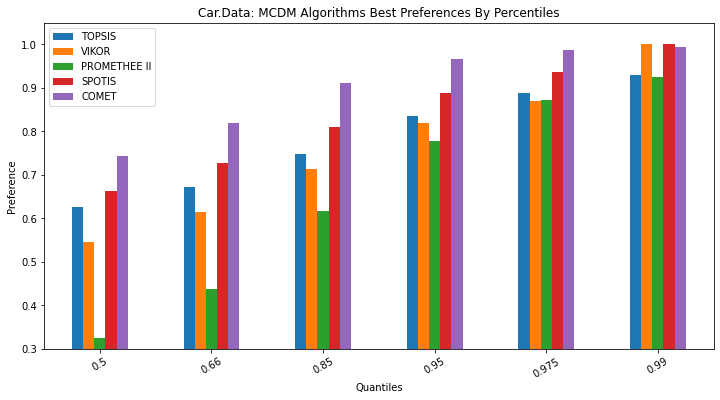

In [105]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 10))
car_results.plot(kind = 'bar', figsize = (12,6))
plt.title('Car.Data: MCDM Algorithms Best Preferences By Percentiles')
plt.xticks(rotation=30, horizontalalignment="center")
plt.xlabel("Quantiles")
plt.ylabel("Preference")
plt.ylim([0.3,1.05])
plt.show()
plt.close()

<Figure size 1008x720 with 0 Axes>

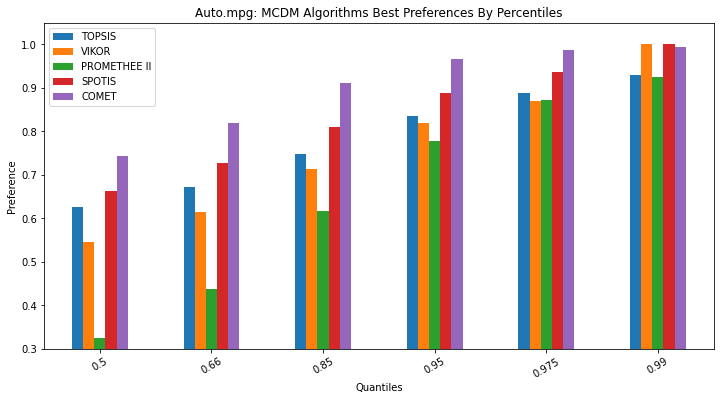

In [106]:
fig = plt.figure(figsize=(14, 10))
car_results.plot(kind = 'bar', figsize = (12,6))
plt.title('Auto.mpg: MCDM Algorithms Best Preferences By Percentiles')
plt.xticks(rotation=30, horizontalalignment="center")
plt.xlabel("Quantiles")
plt.ylabel("Preference")
plt.ylim([0.3,1.05])
plt.show()
plt.close()